In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import pathlib
import os

## Extracting the data from gdrive

In [2]:
file = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Tensorflow Projects/Image Classification Project/Intel Classification/seg_pred.zip", "r")
file.extractall()
file.close()

In [3]:
file = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Tensorflow Projects/Image Classification Project/Intel Classification/seg_test.zip", "r")
file.extractall()
file.close()

file = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Tensorflow Projects/Image Classification Project/Intel Classification/seg_train.zip", "r")
file.extractall()
file.close()

## Surfing into the dataset

In [8]:
path = pathlib.Path("seg_train")
class_names = []
for i in path.glob("*"):
  class_names.append(i.name)


In [9]:
import matplotlib.image as mpimg
import random

In [10]:
def random_image(base_folder, target_folder):

  target_file = base_folder + target_folder
  random_img = random.sample(os.listdir(target_file), 1)

  img = mpimg.imread(target_file + "/" + random_img[0])
  plt.imshow(img)

  plt.title(target_folder)

  plt.axis(False)

  print(f"Image Shape : {img.shape}") 

Image Shape : (150, 150, 3)
Image Shape : (150, 150, 3)
Image Shape : (150, 150, 3)
Image Shape : (150, 150, 3)
Image Shape : (150, 150, 3)
Image Shape : (150, 150, 3)
Image Shape : (150, 150, 3)
Image Shape : (150, 150, 3)
Image Shape : (150, 150, 3)


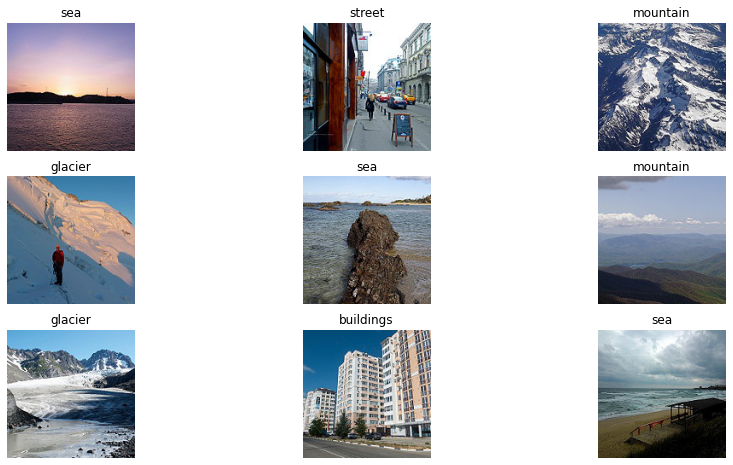

In [11]:
plt.figure(figsize = (15, 8))
for i in range(1, 10):
  plt.subplot(3, 3, i)
  random_image(base_folder = "/content/seg_train/", target_folder = random.choice(class_names))

## PreProcessing the dataset 

In [13]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [17]:
train_path = "/content/seg_train"
test_path = "/content/seg_test"

In [40]:
train_dataset = image_dataset_from_directory(train_path, 
                                             image_size = (224,224), 
                                             batch_size = 32, 
                                             validation_split = 0.3,
                                             subset = "training",
                                             seed = 123)

valid_dataset = image_dataset_from_directory(train_path, 
                                             image_size = (224,224), 
                                             batch_size = 32, 
                                             validation_split = 0.3,
                                             subset = "validation",
                                             seed = 123)


test_dataset = image_dataset_from_directory(test_path, 
                                            image_size = (224,224), 
                                            shuffle= False,
                                             batch_size = 32, 
                                             seed = 123)

Found 14034 files belonging to 6 classes.
Using 9824 files for training.
Found 14034 files belonging to 6 classes.
Using 4210 files for validation.
Found 3000 files belonging to 6 classes.


In [41]:
class_names = train_dataset.class_names

ytrue  = []
for image, label in test_dataset:
  for i in label:
    ytrue.append(class_names[i])
len(ytrue)


3000

## Model Creation

### PreFetching

In [42]:
# It will work when you use image_dataset_from_directory

train_data = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_data = valid_dataset.prefetch(tf.data.AUTOTUNE)

### Data Augmentation

In [43]:
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = tf.keras.models.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [94]:
def pretrained_model(model):

  base_model = model(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")
  base_model.trainable = False

  input = tf.keras.layers.Input(shape = (224, 224, 3))

  x = data_augmentation(input)

  x = base_model(x, training = False)

  x = tf.keras.layers.GlobalAveragePooling2D(name = "pooling_layer")(x)

  # x = tf.keras.layers.Flatten()(x)

  x = tf.keras.layers.Dense(100, activation = "relu")(x)

  x = tf.keras.layers.Dropout(0.4)(x)

  x = tf.keras.layers.Dense(10, activation = "relu")(x)

  output = tf.keras.layers.Dense(6, activation = "softmax", name= "output_layer")(x)

  model = tf.keras.models.Model(input, output)

  return model


In [95]:
model_1 = pretrained_model(model = tf.keras.applications.EfficientNetB3)

# model_1.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer = "adam", 
                metrics = "accuracy")

In [96]:
model_1.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 pooling_layer (GlobalAverag  (None, 1536)             0         
 ePooling2D)                                                     
                                                                 
 dense_20 (Dense)            (None, 100)               153700    
                                                                 
 dropout_10 (Dropout)        (None, 100)               0   

In [93]:
initial_epoch = 10
history_1 = model_1.fit(train_dataset, 
                        epochs = initial_epoch, 
                        steps_per_epoch = len(train_dataset), 
                        validation_data = valid_dataset, 
                        validation_steps = len(valid_dataset))

Epoch 1/10


InvalidArgumentError: ignored

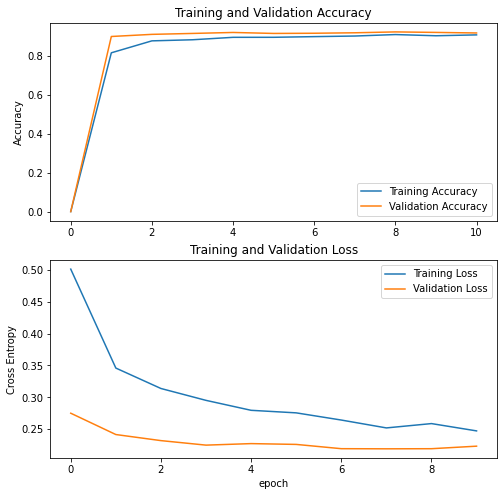

In [81]:
acc = [0.] + history_1.history['accuracy']
val_acc = [0.] + history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Making Predictions

In [82]:
from sklearn.metrics import classification_report

In [83]:
ypred=[]

preds=model_1.predict(test_dataset, verbose=1)
for i, p in enumerate(preds):
    index=np.argmax(p)
    klass=class_names[index] 
    ypred.append(klass)  
    
ypred=np.array(ypred)
ytrue=np.array(ytrue)
print(len(ypred), len(ytrue))
print(len(class_names))
clr = classification_report(ytrue, ypred, target_names=class_names)
print("Classification Report:\n----------------------\n", clr)    

94/94 [==============================] - 14s 118ms/step
3000 3000
6
Classification Report:
----------------------
               precision    recall  f1-score   support

   buildings       0.93      0.91      0.92       437
      forest       0.99      0.99      0.99       474
     glacier       0.92      0.75      0.82       553
    mountain       0.81      0.90      0.85       525
         sea       0.91      0.98      0.94       510
      street       0.92      0.94      0.93       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



### Evaluation

In [85]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(ypred, ytrue)
sklearn_accuracy

0.9086666666666666

In [88]:
def predict_probability():

  plt.figure(figsize=(15, 10))

  for i in range(6):
    plt.subplot(2, 3, i+1)

    # Choose a random image from a random class 
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_path + "/" + class_name))
    filepath = test_path+"/" + class_name+ "/" + filename  

    # Load the image
    img = tf.keras.preprocessing.image.load_img(filepath, target_size = (224, 224))

    # Convert to Tensor
    img_tensor = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(img), axis = 0)

    # prediction
    pred_prob = model_1.predict(img_tensor)
    result_class_name = class_names[np.argmax(pred_prob)]

    # Plot the image and displaying our model prediction proability
    plt.imshow(img)
    plt.axis(False)

    if class_name == result_class_name: # Change the color of text based on whether prediction is right or wrong
      title_color = "g"
    else:
      title_color = "r"

    plt.title(f"actual: {class_name}, pred: {result_class_name}, prob: {pred_prob.max():.2f}", c=title_color)


1/1 [==============================] - 0s 31ms/step


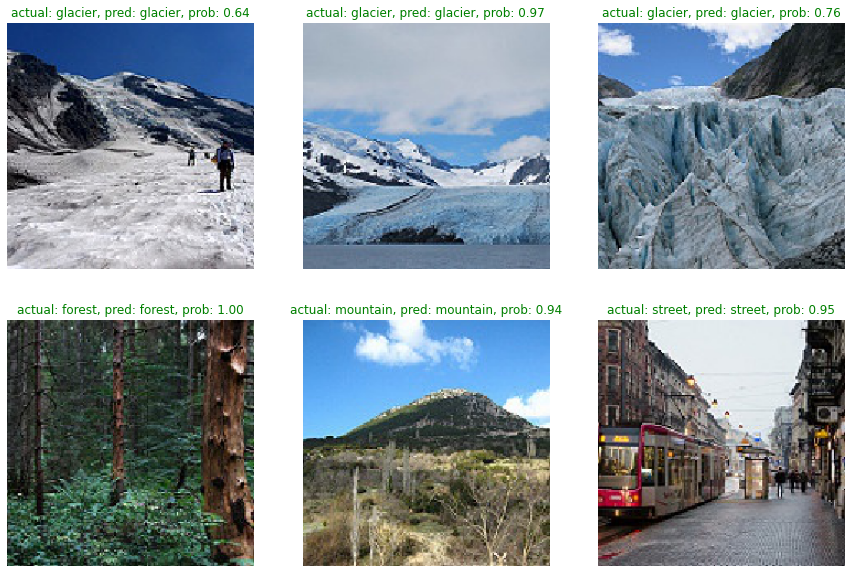

In [89]:
predict_probability()